In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 (default, Oct 12 2021, 13:49:34) \n[GCC 7.5.0]'

In [3]:
import cbf_opt
import numpy as np

In [4]:
from experiment_wrapper.rollout_trajectory import TimeSeriesExperiment, StateSpaceExperiment

In [5]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '28',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [6]:
class ACC_Dynamics(cbf_opt.ControlAffineDynamics):
    STATES = ['P', 'V', 'dP']
    CONTROLS = ['ACC']
    def __init__(self, params, **kwargs):
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[..., 1] + self.f2 * x[..., 1] ** 2
        self.v0 = params["v0"]
        super().__init__(params, **kwargs)

    def state_jacobian(self, state, control, time=0.):
        if state.ndim == 1:
            J = np.zeros((self.n_dims, self.n_dims))
        else:
            J = np.zeros((state.shape[0], self.n_dims, self.n_dims))
            
        J[..., 0, 1] = 1
        J[..., 1, 1] = -1 / self.mass * (self.f1 + 2 * self.f2 * state[..., 1])
        J[..., 2, 1] = -1 
        return J
        
    def open_loop_dynamics(self, state, time=0.):
        f = np.zeros_like(state)
        f[..., 0] = state[..., 1]
        f[..., 1] = -1 / self.mass * self.rolling_resistance(state)
        f[..., 2] = self.v0 - state[..., 1]
        return f

    def control_matrix(self, state, time=0.):
        if state.ndim == 1:
            B = np.zeros((self.n_dims, self.control_dims))
        else: 
            B = np.zeros((state.shape[0], self.n_dims, self.control_dims))
        B[..., 1, 0] = 1 / self.mass 
        return B

In [7]:
class ACC_CBF(cbf_opt.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        self.Th = params["Th"]
        self.cd = params["cd"]
        super().__init__(dynamics, params, **kwargs)

    def vf(self, state, time=None):
        return state[..., 2] - self.Th * state[..., 1] - (state[..., 1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=None):
        return 0.0
    
    def _grad_vf(self, state, time=None):
        dvf_dx = np.zeros_like(state)
        dvf_dx[..., 1] = - self.Th  - (state[..., 1] - self.dynamics.v0) / (self.cd * self.dynamics.g)
        dvf_dx[..., 2] = 1.0
        return dvf_dx

In [8]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)

In [9]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(acc, cbf_params)

In [10]:
vd = 24
umax = np.array([cbf_params['cd'] * params['mass'] * params['g']])
umin = -umax
alpha = lambda x: 5 * x
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-1000 * (x[..., 1] - vd), umin, umax))
acc_asif = cbf_opt.ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy, umin=umin, umax=umax)


In [11]:
x0 = np.array([0, 30, 100])
x0_2 = np.array([0, 25, 70])
rollout_opt = TimeSeriesExperiment('rollout_opt', start_x=np.array([x0, x0_2]), n_sims_per_start=1, t_sim=10)

In [12]:
import logging
logging.getLogger().setLevel(logging.ERROR)
results_df = rollout_opt.run(acc, {'Nominal': nominal_policy, 'CBF': acc_asif})

Controller rollout: 100%|██████████| 1000/1000 [00:05<00:00, 167.75it/s]


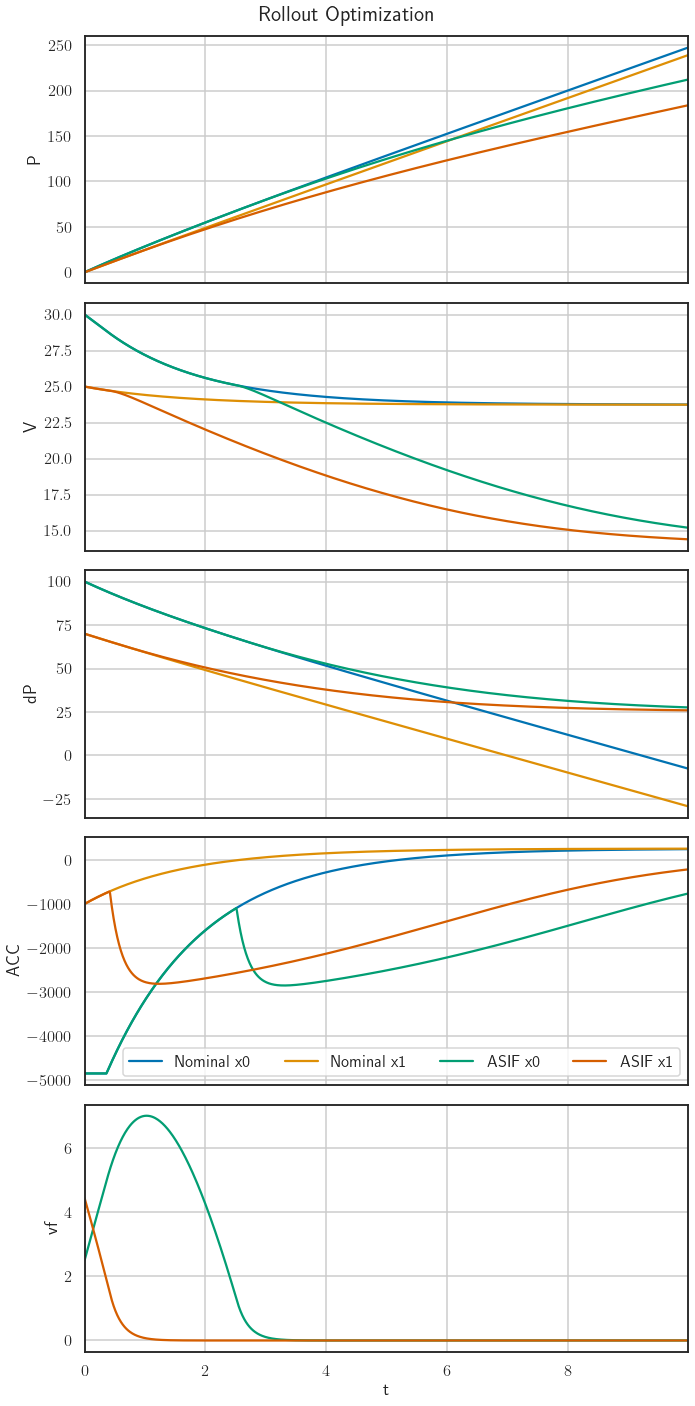

In [13]:
fig_handle = rollout_opt.plot(acc, results_df, extra_measurements=['vf'])
fig = fig_handle[0][1]
fig.suptitle('Rollout Optimization')
fig.tight_layout()
for ax in fig.axes:
    ax.grid(True)
fig.axes[-2].legend(['Nominal x0', 'Nominal x1', 'ASIF x0', 'ASIF x1'], ncol=4);

In [14]:
ss_exp = StateSpaceExperiment('ss_opt', x_indices=[1, 2], start_x =np.array([x0, x0_2]), n_sims_per_start=1, t_sim=10)

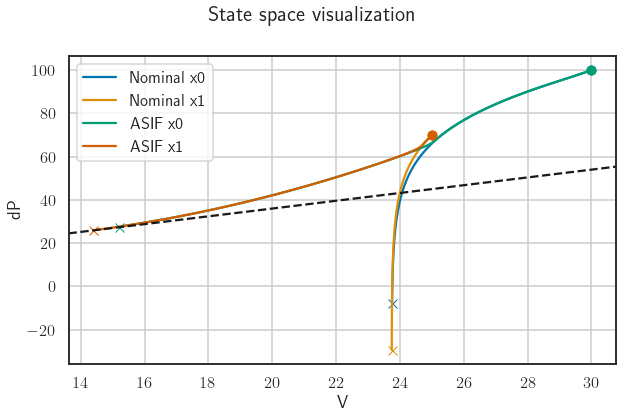

In [15]:
fig_handle = ss_exp.plot(acc, results_df)
fig_ss = fig_handle[0][1]
fig_ss.suptitle('State space visualization')
fig_ss.tight_layout()
fig_ss.axes[0].grid(True)
xmin, xmax = fig_ss.axes[0].get_xlim()
fig_ss.axes[0].set_xlim(xmin, xmax)
xrange = np.linspace(xmin, xmax, 100)
fig_ss.axes[0].legend(fig_ss.axes[0].get_lines()[::3], ['Nominal x0', 'Nominal x1', 'ASIF x0', 'ASIF x1'])
fig_ss.axes[0].plot(xrange, acc_cbf.Th * xrange, '--k');

## Alternative method: Manually updating 
Does not make use of the `experiment_wrapper` package

In [16]:
x0 = np.array([0, 30, 100])
states = [x0]
control = []
control_filt = []
control_filt_gen = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_gen = x0
states_filt_gen = [x0]
vf = [acc_cbf.vf(x_filt)]

ts = np.arange(0, 20, params['dt'])

x = x0
for t in ts:  
    input_nom = nominal_policy(x, t)
    x = acc.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

from tqdm import tqdm
for t in tqdm(ts):
    input_mod = np.atleast_1d(np.clip(acc_asif(x_filt), umin, umax))

    x_filt = acc.step(x_filt, input_mod)
    states_filt.append(x_filt)
    control_filt.append(input_mod)
    vf.append(acc_cbf.vf(x_filt))


100%|██████████| 2000/2000 [00:06<00:00, 315.52it/s]


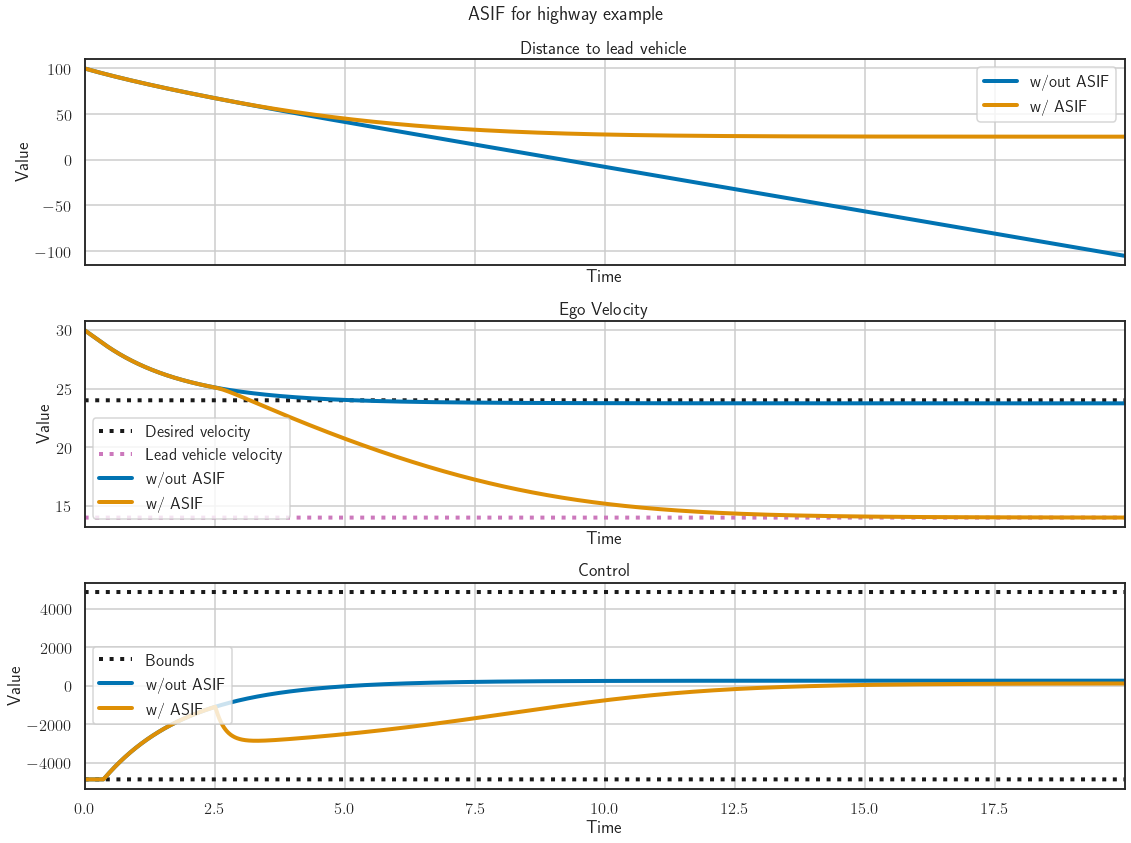

In [17]:
states = np.array(states)
states_filt = np.array(states_filt)
states_filt_gen = np.array(states_filt_gen)

ts = np.arange(0, 20, params['dt'])
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 4
fig.suptitle("ASIF for highway example")
ax[0].set_title("Distance to lead vehicle")
ax[0].plot(ts[:states.shape[0]-1], states[1:,2], label='w/out ASIF')
ax[0].plot(ts[:states_filt.shape[0]-1], states_filt[1:,2], label='w/ ASIF')

ax[0].legend()
ax[1].set_title("Ego Velocity")
ax[1].plot(ts, vd * np.ones_like(ts), ':k', label='Desired velocity')
ax[1].plot(ts, params['v0'] * np.ones_like(ts), ':m', label='Lead vehicle velocity')
ax[1].plot(ts[:states.shape[0]-1], states[1:,1], label='w/out ASIF')
ax[1].plot(ts[:states_filt.shape[0]-1], states_filt[1:,1], label='w/ ASIF')

ax[1].legend()
ax[2].set_title("Control")
ax[2].plot(ts, np.ones_like(ts) * umax, ':k', label='Bounds')
ax[2].plot(ts, np.ones_like(ts) * umin, ':k', label='__nolegend__')
ax[2].plot(ts[:len(control)], control, label='w/out ASIF')
ax[2].plot(ts[:len(control_filt)], np.array(control_filt)[..., 0], label='w/ ASIF')

ax[2].legend()
for axi in ax:
    axi.grid()
    axi.set_xlabel("Time")
    axi.set_ylabel("Value")
    axi.set_xlim([ts[0], ts[-1]])
fig.tight_layout()
